Vážená fúzia

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import json
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle
from transformers import VisualBertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer

import torch.nn as nn

class BiLSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=128, max_length=100):
        super(BiLSTM_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h = torch.cat((h_n[0], h_n[1]), dim=1)
        return self.fc(h)


#ResNet extraktor
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=False)
        self.base = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(2048, 128)

    def forward(self, x):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

#trieda Dataset
class FusionJSONLDataset(Dataset):
    def __init__(self, jsonl_path, img_root, vocab):
        self.data = [json.loads(l.strip()) for l in open(jsonl_path)]
        self.img_root = img_root
        self.vocab = vocab
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)), transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

    def text_to_seq(self, text, max_len=100):
        seq = [self.vocab.get(w, 1) for w in text.split()]
        return seq[:max_len] + [0]*(max_len - len(seq))

    def __getitem__(self, idx):
        item = self.data[idx]
        img = Image.open(os.path.join(self.img_root, item["img"])).convert("RGB")
        text = torch.tensor(self.text_to_seq(item["text"]), dtype=torch.long)
        label = torch.tensor(item["label"], dtype=torch.float32)
        return self.transform(img), text, label

    def __len__(self):
        return len(self.data)

In [3]:
pip install torchinfo

In [4]:
import os
import json
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle
from transformers import VisualBertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer

Prvých 3 riadky:
{'id': '15740', 'img': 'img/15740.png', 'label': 1, 'text': 'when someone tells you how to bbq'}
{'id': '38794', 'img': 'img/38794.png', 'label': 1, 'text': "when they say white folks don't know how to cook"}
{'id': '60792', 'img': 'img/60792.png', 'label': 1, 'text': 'the original derp-face'}
Veľkosť slovníka: 3183


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



==== Výsledky pre váhy: text=0.0, image=1.0 ====
Accuracy : 0.8155
Precision: 0.8188
Recall   : 0.7809
F1-score : 0.7924


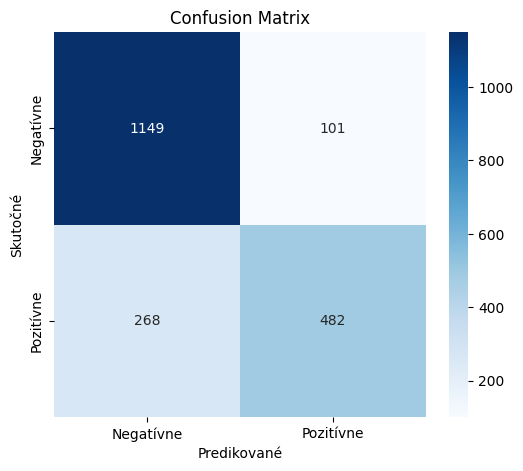


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1417 vzoriek
 - Trieda 1 (Pozitívne): 583 vzoriek

==== Výsledky pre váhy: text=0.1, image=0.9 ====
Accuracy : 0.8145
Precision: 0.8179
Recall   : 0.7796
F1-score : 0.7911


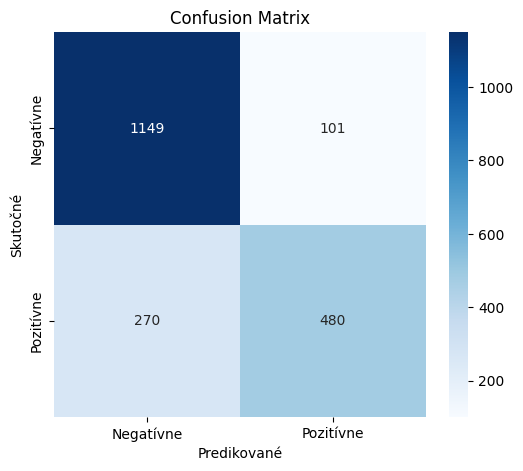


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1419 vzoriek
 - Trieda 1 (Pozitívne): 581 vzoriek

==== Výsledky pre váhy: text=0.2, image=0.8 ====
Accuracy : 0.8150
Precision: 0.8198
Recall   : 0.7792
F1-score : 0.7911


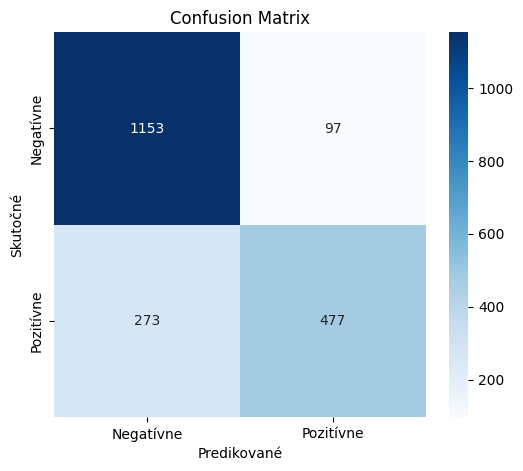


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1426 vzoriek
 - Trieda 1 (Pozitívne): 574 vzoriek

==== Výsledky pre váhy: text=0.3, image=0.7 ====
Accuracy : 0.8145
Precision: 0.8201
Recall   : 0.7780
F1-score : 0.7902


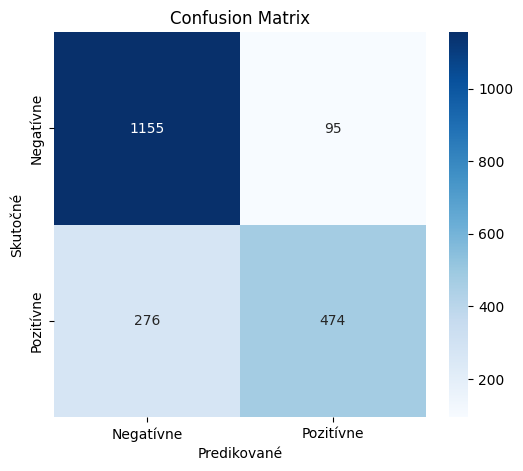


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1431 vzoriek
 - Trieda 1 (Pozitívne): 569 vzoriek

==== Výsledky pre váhy: text=0.4, image=0.6 ====
Accuracy : 0.8140
Precision: 0.8212
Recall   : 0.7763
F1-score : 0.7889


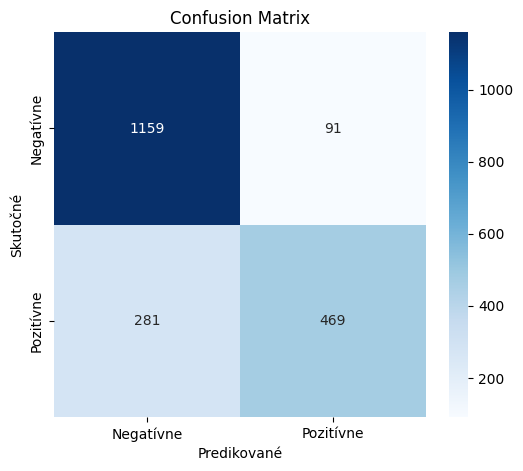


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1440 vzoriek
 - Trieda 1 (Pozitívne): 560 vzoriek

==== Výsledky pre váhy: text=0.5, image=0.5 ====
Accuracy : 0.8135
Precision: 0.8220
Recall   : 0.7748
F1-score : 0.7877


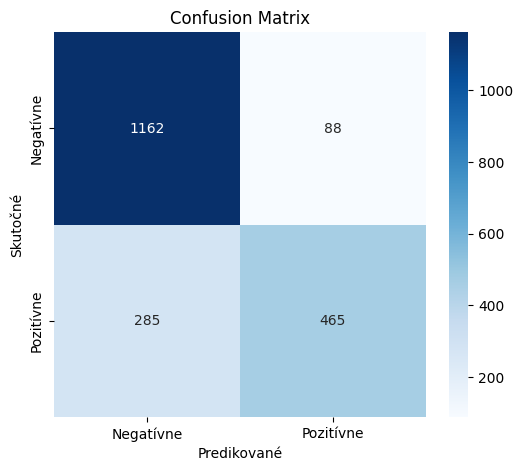


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1447 vzoriek
 - Trieda 1 (Pozitívne): 553 vzoriek

==== Výsledky pre váhy: text=0.6, image=0.4 ====
Accuracy : 0.8120
Precision: 0.8224
Recall   : 0.7717
F1-score : 0.7851


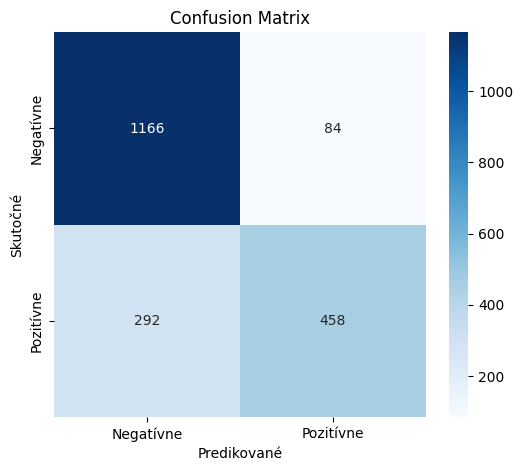


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1458 vzoriek
 - Trieda 1 (Pozitívne): 542 vzoriek

==== Výsledky pre váhy: text=0.7, image=0.3 ====
Accuracy : 0.8125
Precision: 0.8264
Recall   : 0.7703
F1-score : 0.7843


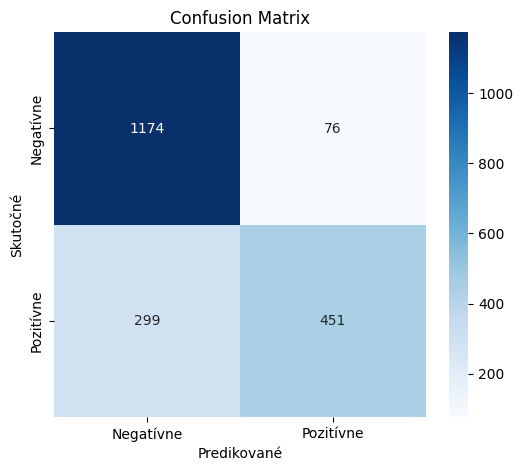


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1473 vzoriek
 - Trieda 1 (Pozitívne): 527 vzoriek

==== Výsledky pre váhy: text=0.8, image=0.2 ====
Accuracy : 0.8065
Precision: 0.8313
Recall   : 0.7575
F1-score : 0.7727


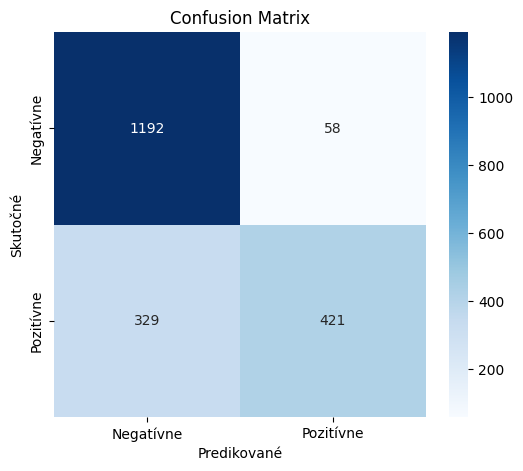


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1521 vzoriek
 - Trieda 1 (Pozitívne): 479 vzoriek

==== Výsledky pre váhy: text=0.9, image=0.1 ====
Accuracy : 0.7625
Precision: 0.8184
Recall   : 0.6921
F1-score : 0.7007


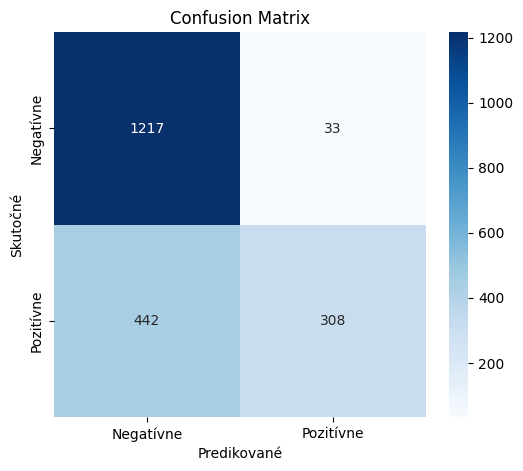


Počet vzoriek podľa predikovanej triedy:
 - Trieda 0 (Negatívne): 1659 vzoriek
 - Trieda 1 (Pozitívne): 341 vzoriek


In [ ]:
import os
import json
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import defaultdict
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#načítanie dát a modelov
jsonl_path = "/content/drive/MyDrive/data/test_unseen.jsonl"
img_root = "/content/drive/MyDrive"
resnet_model_path = "/content/drive/MyDrive/resnet_own.pth"
lstm_model_path = "/content/drive/MyDrive/bilstm_model.pth"


with open(jsonl_path, 'r', encoding='utf-8') as f:
    data = [json.loads(line.strip()) for line in f]

print("Prvé 3 riadky:")
for d in data[:3]:
    print(d)

#vocab a tokenizer
def build_vocab(data, min_freq=1, max_words=10000):
    counter = defaultdict(int)
    for item in data:
        for word in item['text'].lower().split():
            counter[word] += 1
    sorted_words = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:max_words]
    word2idx = {'<pad>': 0, '<unk>': 1}
    for word, count in sorted_words:
        if count >= min_freq:
            word2idx[word] = len(word2idx)
    return word2idx

def simple_tokenizer(text, word2idx, max_length=100):
    tokens = text.lower().split()
    token_ids = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
    if len(token_ids) < max_length:
        token_ids += [word2idx['<pad>']] * (max_length - len(token_ids))
    else:
        token_ids = token_ids[:max_length]
    return token_ids

word2idx = build_vocab(data)
print(f"Veľkosť slovníka: {len(word2idx)}")

#obrazkove transformacie
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


class JSONLFusionDataset(Dataset):
    def __init__(self, data_list, word2idx, img_root, transform=None, max_length=100):
        self.data = data_list
        self.word2idx = word2idx
        self.img_root = img_root
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text_tensor = torch.tensor(
            simple_tokenizer(item['text'], self.word2idx, self.max_length),
            dtype=torch.long)
        image_path = os.path.join(self.img_root, item['img'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(item['label'], dtype=torch.float)
        return text_tensor, image, label

dataset = JSONLFusionDataset(data, word2idx, img_root, transform=image_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

#architektura modelu
class BiLSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length, lstm_units=64, dropout_rate=0.5):
        super(BiLSTM_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, 128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(256, lstm_units, batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(2 * lstm_units)
        self.fc1 = nn.Linear(2 * lstm_units, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ResNetBinaryClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetBinaryClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

#načítanie modelov
text_model = BiLSTM_Model(vocab_size=len(word2idx), embedding_dim=100, max_length=100).to(device)
text_state = torch.load(lstm_model_path, map_location=device)
text_model = BiLSTM_Model(vocab_size=10000, embedding_dim=100, max_length=100).to(device)
text_model.eval()

resnet_model = ResNetBinaryClassifier(num_classes=2).to(device)
resnet_state = torch.load(resnet_model_path, map_location=device)
resnet_model.load_state_dict(resnet_state)
resnet_model.eval()

#fúzna funkcia s metrikami
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

def evaluate_fusion_with_metrics(text_model, image_model, dataloader, text_weight=0.6, image_weight=0.4, return_preds=False):
    text_model.eval()
    image_model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for text_input, image_input, labels in dataloader:
            text_input = text_input.to(device)
            image_input = image_input.to(device)
            labels = labels.to(device)

            text_output = text_model(text_input).squeeze(1)
            text_prob = torch.sigmoid(text_output)

            image_output = image_model(image_input)
            image_prob = torch.softmax(image_output, dim=1)[:, 1]

            combined_score = text_weight * text_prob + image_weight * image_prob
            preds = (combined_score >= 0.5).long()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(combined_score.cpu().numpy())

    y_true = np.array(all_labels).astype(int)
    y_pred = np.array(all_preds).astype(int)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\n==== Výsledky pre váhy: text={text_weight:.1f}, image={image_weight:.1f} ====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

    #confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Negatívne', 'Pozitívne']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predikované")
    plt.ylabel("Skutočné")
    plt.title("Confusion Matrix")
    plt.show()

    #počet predikovaných tried
    unique, counts = np.unique(y_pred, return_counts=True)
    print("\nPočet vzoriek podľa predikovanej triedy:")
    for u, c in zip(unique, counts):
        print(f" - Trieda {u} ({'Negatívne' if u == 0 else 'Pozitívne'}): {c} vzoriek")

    if return_preds:
        return y_pred, y_true, all_probs


#testovanie koombinácií váh
best_acc = 0
best_weights = (0.0, 0.0)

for i in range(0, 11):
    text_w = i / 10
    image_w = 1.0 - text_w

    preds, labels, _ = evaluate_fusion_with_metrics(
        text_model=text_model,
        image_model=resnet_model,
        dataloader=dataloader,
        text_weight=text_w,
        image_weight=image_w,
        return_preds=True
    )

    acc = accuracy_score(labels, preds)
    if acc > best_acc:
        best_acc = acc
        best_weights = (text_w, image_w)

print(f"\n Najlepšia presnosť: {best_acc:.4f} pri váhach text={best_weights[0]:.1f}, image={best_weights[1]:.1f}")
